In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)
    
class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [4]:
model = ResNet9(3, 10)
model = model.to(device)
model.load_state_dict(torch.load("cifar10-resnet9.pth"))
model.eval()

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [5]:
#Data Set is stored externally from this folder as to not overencumber GitHub Repository
from torchvision.datasets.utils import download_url
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '../CiFar10-Data Set')

Using downloaded and verified file: ../CiFar10-Data Set\cifar10.tgz


In [6]:
import os, tarfile
try:
    if (len(os.listdir('../CiFar10-Data Set/cifar10')) == 2):
        pass
except:
    with tarfile.open('../CiFar10-Data Set/cifar10.tgz', 'r:gz') as tar:
        tar.extractall(path='../CiFar10-Data Set')

In [7]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
data_dir = '../CiFar10-Data Set/cifar10'

In [8]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
tfms = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(mean, std)]
)
test_data_set = ImageFolder(data_dir+'/test', transform=tfms)

In [9]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_data_set.classes[preds[0].item()]

img, label = test_data_set[0]
predict_image(img, model)


'airplane'

In [10]:
dl = torch.utils.data.DataLoader(test_data_set, batch_size=1, shuffle=False)
dl

In [11]:
for image, label in dl:
    print(image.size())
    break

torch.Size([1, 3, 32, 32])


In [12]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        print(model(images.to(device)))
        images = denormalize(images, mean, std)
        print(images.shape)
        ax.imshow(images.squeeze(0).permute(1,2,0).clamp(0,1))
        break

tensor([[23.6674, 14.3957, 16.9693, 15.6285, 12.2386, 11.8358, 12.3943, 11.9871,
         18.7864, 15.7737]], device='cuda:0', grad_fn=<AddmmBackward>)
torch.Size([1, 3, 32, 32])


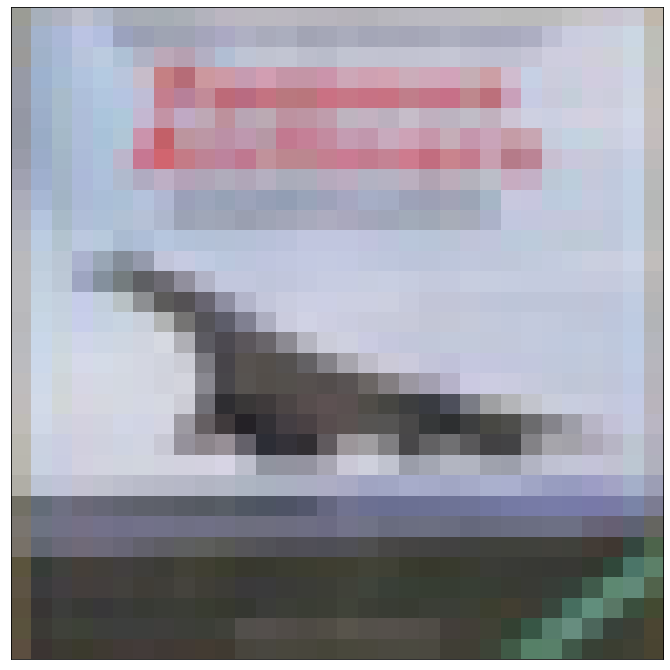

In [14]:
show_batch(dl)

In [15]:
def test(model, device, dl, epsilon):
    adversarial_images = []
    correct = 0
    init_correct = 0
    
    for img, label in dl:
        img, label = img.to(device), label.to(device)
        img.requires_grad = True
        output = model(img)
        if output.max(1, keepdim=True)[1] == label:
            init_correct += 1

        loss = F.cross_entropy(output, label)

        model.zero_grad()
        loss.backward()

        data_grad = img.grad.data.sign()

        perturbed_image = img + epsilon*data_grad

        perturbed_image = torch.clamp(perturbed_image, 0, 1)

        output = model(perturbed_image)

        final_pred = output.max(1, keepdim=True)[1]

        if final_pred == label:
            correct += 1
        else:
            adversarial_images.append((perturbed_image.cpu(), label.cpu()))
        
    return init_correct/len(dl), correct/len(dl), adversarial_images

In [16]:
epsilon = .25
init_accuracy, accuracy, adv_imgs = test(model, device, dl, epsilon)
print(init_accuracy)
print(accuracy)
print(len(adv_imgs))
print(adv_imgs[0][0].size())

0.9226
0.2058
7942
torch.Size([1, 3, 32, 32])


In [17]:
data_set = test_data_set = ImageFolder(data_dir+'/train', transform=tfms)
print(data_set.classes)
print(os.listdir(data_dir + "/train"))
dl = torch.utils.data.DataLoader(data_set, batch_size=1, shuffle=False)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [18]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return F.relu(x)
model.classifier[3] = Identity()
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [19]:
outputs = np.empty((len(dl) + len(adv_imgs), 512)) #+ len(adv_imgs)
labels = []
x=0
for img, label in dl:
    img = img.to(device)
    output = model(img)
    outputs[x] = output.squeeze().tolist()
    labels.append(test_data_set.classes[int(label.item())])
    x += 1

for img, label in adv_imgs:
    img = img.to(device)
    output = model(img)
    outputs[x] = output.squeeze().tolist()
    labels.append(test_data_set.classes[int(label.item())])
    x += 1

print(outputs.shape)
print(len(labels))
print(x)

(57942, 512)
57942
57942


In [20]:
outputs

array([[0.        , 1.22844481, 0.29369628, ..., 1.15117323, 0.99593705,
        1.09871697],
       [0.10439237, 0.56185728, 0.74313301, ..., 0.55841357, 0.58430159,
        1.10972118],
       [0.37754333, 1.44647837, 0.54533195, ..., 2.20371222, 0.55439204,
        2.41291022],
       ...,
       [0.10491717, 0.4652757 , 0.        , ..., 0.53085047, 1.11520576,
        0.57391977],
       [0.09268227, 0.27811158, 0.46552613, ..., 0.71022326, 0.32739198,
        0.44351533],
       [0.24159102, 0.70777935, 1.06833303, ..., 0.43988466, 1.07633197,
        0.54617113]])

In [21]:
print(labels[:5])

['airplane', 'airplane', 'airplane', 'airplane', 'airplane']


In [22]:
import time
import seaborn as sns
from sklearn import manifold
from sklearn.manifold import TSNE
import pandas as pd

In [23]:
time_start = time.time()
tsne2d = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne2d_results = tsne2d.fit_transform(outputs)
print('t-SNE done in {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 57942 samples in 0.039s...
[t-SNE] Computed neighbors for 57942 samples in 73.702s...
[t-SNE] Computed conditional probabilities for sample 1000 / 57942
[t-SNE] Computed conditional probabilities for sample 2000 / 57942
[t-SNE] Computed conditional probabilities for sample 3000 / 57942
[t-SNE] Computed conditional probabilities for sample 4000 / 57942
[t-SNE] Computed conditional probabilities for sample 5000 / 57942
[t-SNE] Computed conditional probabilities for sample 6000 / 57942
[t-SNE] Computed conditional probabilities for sample 7000 / 57942
[t-SNE] Computed conditional probabilities for sample 8000 / 57942
[t-SNE] Computed conditional probabilities for sample 9000 / 57942
[t-SNE] Computed conditional probabilities for sample 10000 / 57942
[t-SNE] Computed conditional probabilities for sample 11000 / 57942
[t-SNE] Computed conditional probabilities for sample 12000 / 57942
[t-SNE] Computed conditional probabilities for s

In [24]:
tsne2_subset = pd.DataFrame(columns=['tsne-2d-one', 'tsne-2d-two'])

tsne2_subset['tsne-2d-one'] = tsne2d_results[:,0]
tsne2_subset['tsne-2d-two'] = tsne2d_results[:,1]

print(tsne2_subset.head())

   tsne-2d-one  tsne-2d-two
0     1.962464     0.167825
1     3.151874     0.273918
2     2.375254     0.163693
3     2.548490    -0.399122
4     1.395799    -0.288731


<Figure size 720x720 with 0 Axes>

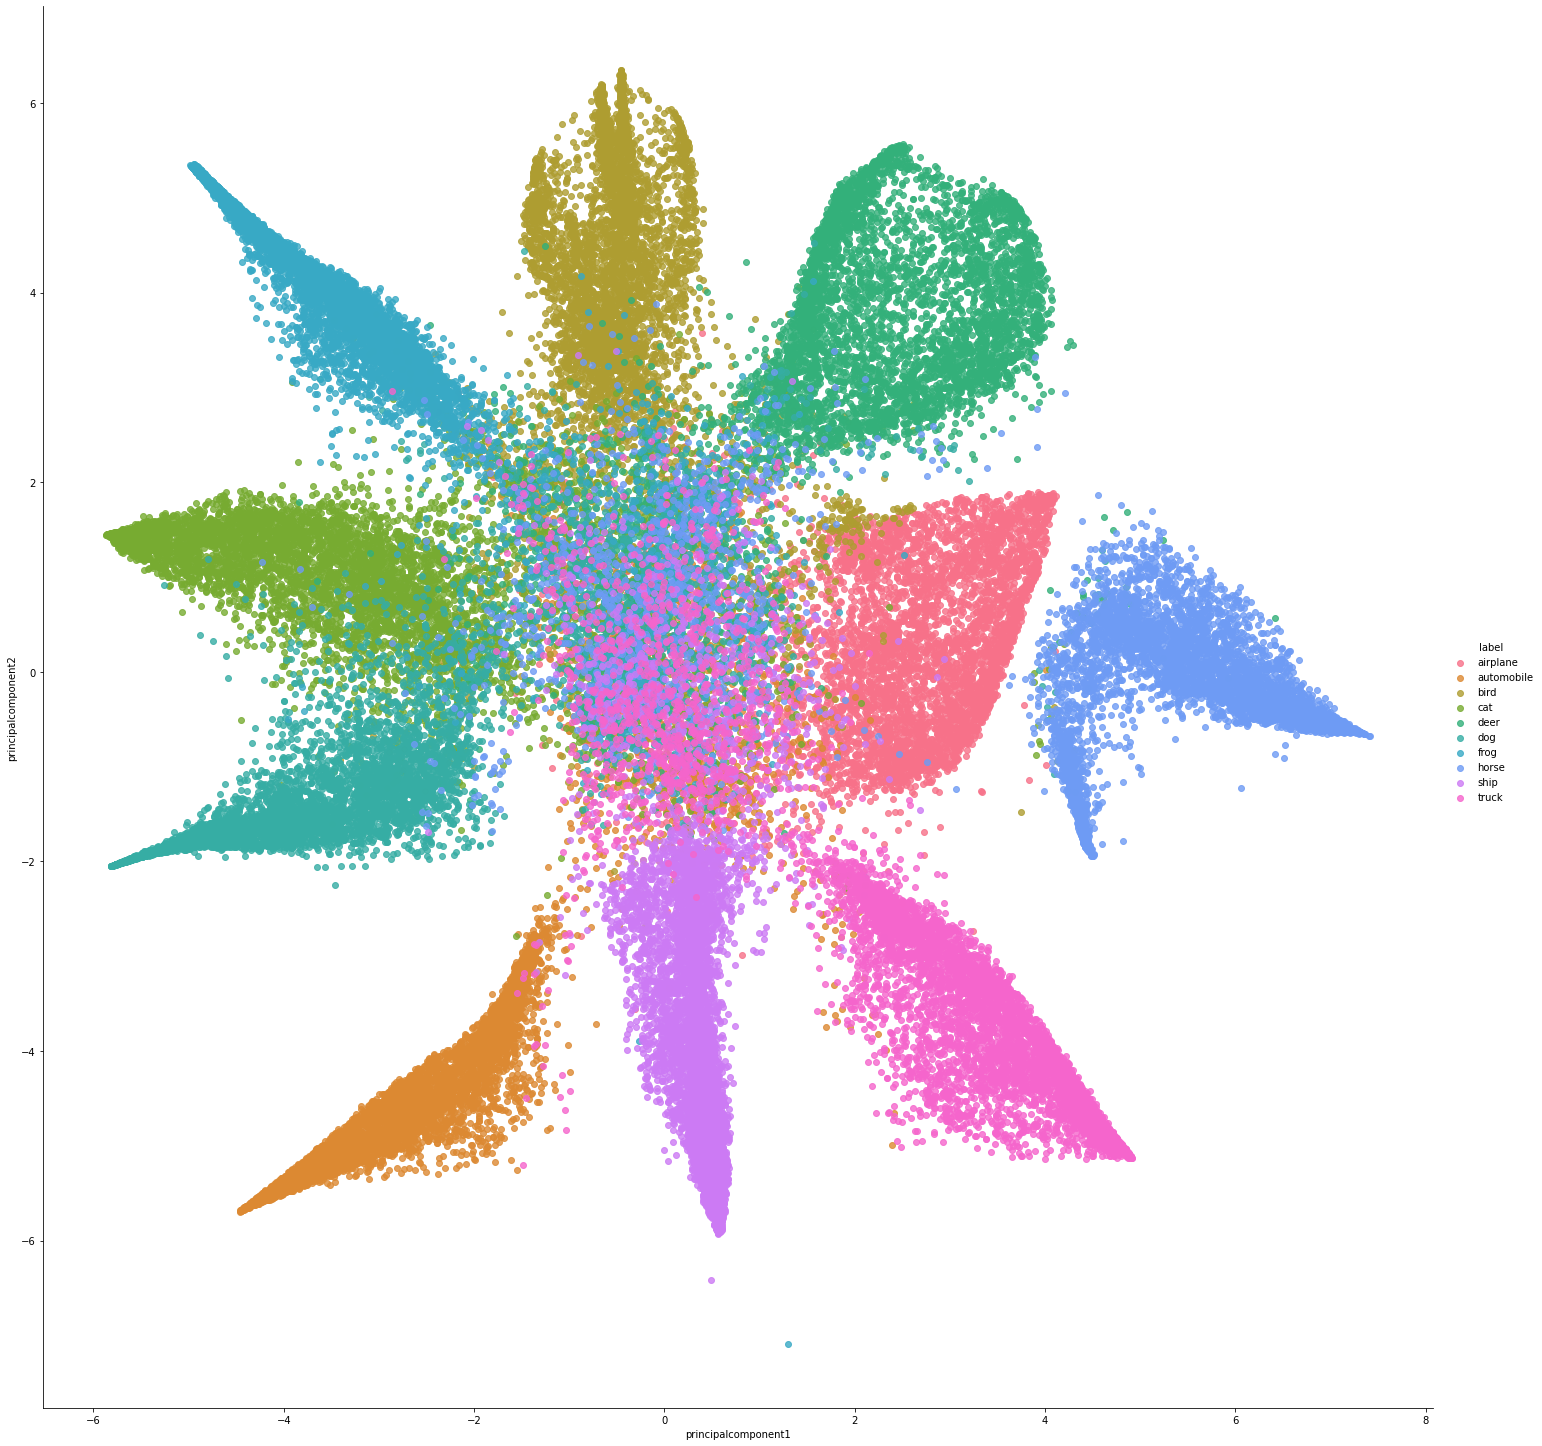

<Figure size 720x720 with 0 Axes>

In [25]:
principalDf = pd.concat([tsne2_subset,pd.DataFrame(labels)],axis = 1,join='inner', ignore_index=True)
principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"]

flatui = ["#9b59b6", "#3498db", "orange"]
sns.set_palette(flatui)
sns.lmplot( x="principalcomponent1", y="principalcomponent2", data=principalDf, fit_reg=False, height=20,
           hue='label', legend=True)

plt.figure(figsize=(10,10))